In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
obs_rate = 100

def load_file(filename):
    phase = np.fromfile(filename, dtype = 'float32').reshape((-1,2)).astype('double')
    start = np.datetime64(filename.strip('.f32x2').split('_')[-1])
    timestamps = start + np.timedelta64(1, 'ns') * np.arange(phase.shape[0]) * 1e9 / obs_rate
    for j in range(phase.shape[1]):
        phase[:,j] = np.unwrap(phase[:,j])
    return xr.Dataset({'phase' : (('time', 'signal'), phase)}, coords = {'time' : timestamps, 'signal' : ['bpsk', 'cw']})

In [3]:
morning = load_file('phase_2019-11-10T11:08:40.683705.f32x2').sel(time = slice('2019-11-10T11:10:00', '2019-11-10T11:20:00'))

In [4]:
evening = load_file('phase_2019-11-10T19:58:44.075224.f32x2').sel(time = slice('2019-11-10T20:11:00', '2019-11-11T00:00:00'))
evening2 = evening.sel(time = slice('2019-11-10T20:11:00', '2019-11-10T21:20:00'))

In [5]:
def avar(series, skip, freq = 10e9, overlapping = False):
    x = series.values/(2*np.pi*freq)
    
    tau = skip / obs_rate
    if overlapping:
        y = x[:-2*skip] - 2*x[skip:-skip] + x[2*skip:]
    else:
        z = x[:x.size//skip*skip].reshape((-1,skip))[:,0]
        y = z[:-2] - 2*z[1:-1] + z[2:]
    return np.sqrt(0.5/tau**2*np.average(y**2))

f_up = 2400.3e6
f_down = 10489.8e6
f_LO = f_down - f_up

def get_skips(n):
    if n <= 0:
        return np.array([], dtype = 'int')
    a = int(np.log10(n))
    step = max(10**(a-2), 1)
    return np.concatenate((get_skips(10**a - 1) , np.arange(10**a, n+1, step)))

def avars(data, overlapping = False):
    skips = get_skips(data.coords['time'].size//5)
    taus = skips / obs_rate
    avars_diff = [avar(data.sel(signal = 'cw')['phase'] - data.sel(signal = 'bpsk')['phase'], skip, f_up, overlapping) for skip in skips]
    avars_bpsk = [avar(data.sel(signal = 'bpsk')['phase'], skip, f_down, overlapping) for skip in skips]
    avars_cw = [avar(data.sel(signal = 'cw')['phase'], skip, f_LO, overlapping) for skip in skips]
    return xr.Dataset({'CW-BPSK' : ('tau', avars_diff), 'BPSK' : ('tau', avars_bpsk), 'CW' : ('tau', avars_cw)},\
                     coords = {'tau' : taus})

In [6]:
avars_morning = avars(morning, overlapping = True)

In [7]:
avars_evening = avars(evening, overlapping = True)

In [8]:
avars_evening2 = avars(evening2, overlapping = True)

In [9]:
def plot_avars(avars, label):
    taus = avars.coords['tau']
    plt.loglog(taus, avars['CW-BPSK'], label = f'{label} CW-BPSK')
    plt.loglog(taus, avars['BPSK'], label = f'{label} BPSK')
    plt.loglog(taus, avars['CW'], label = f'{label} CW')

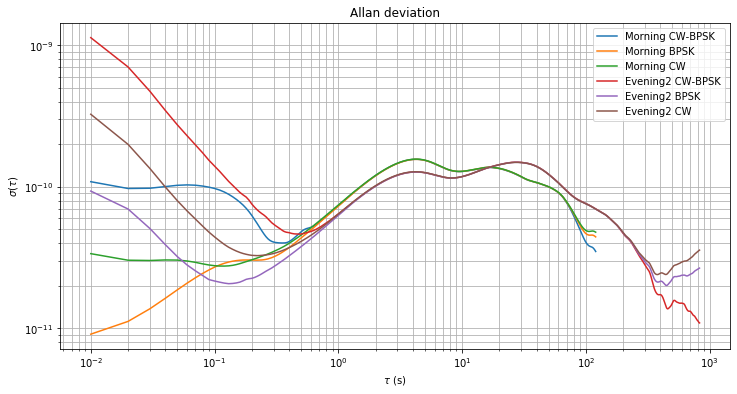

In [10]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_avars(avars_morning, 'Morning')
#plot_avars(avars_evening, 'Evening')
plot_avars(avars_evening2, 'Evening2')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation');

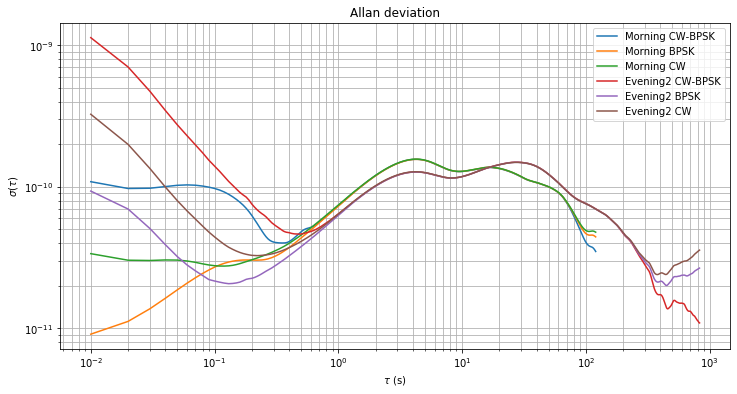

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
plot_avars(avars_morning, 'Morning')
#plot_avars(avars_evening, 'Evening')
plot_avars(avars_evening2, 'Evening2')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation');